In [4]:
import pandas as pd
import numpy as np

import xgboost as xgb
import lightgbm as lgb

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score, KFold

import eli5
from eli5.sklearn import PermutationImportance

In [2]:
pd.set_option('display.max_columns', 250)

In [3]:
df = pd.read_pickle('data/car_clean.pickle')
df.shape

(201357, 101)

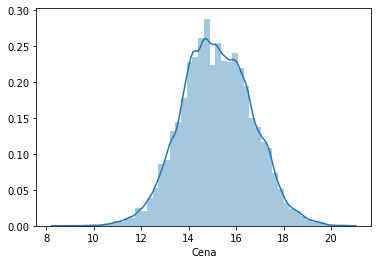

In [5]:
sns.distplot(np.log2(df['Cena']));

In [6]:
def run_model(model, df, feats):
    X = df[ feats ].values
    y = df['Cena'].values
    
    scores = []
    
    folds = KFold(n_splits=3, shuffle=True, random_state=0)
    for train_index, test_index in folds.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        y_train = np.log2( y_train )
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        y_pred = np.exp2( y_pred )
        scores.append(mae(y_test, y_pred))
        
#     scores = cross_val_score(model, X, y, cv = 3, scoring = "neg_mean_absolute_error" )
    return np.mean(scores), np.std(scores)

In [7]:
# cat_feats = df.select_dtypes(np.object).columns.values
# cat_feats

array(['Model pojazdu', 'Wersja', 'Generacja', 'Opis'], dtype=object)

In [9]:
# SUFF = '__cat'
# for feat in cat_feats[:-1]:
#     size = len(df[feat].unique())
#     if size >= 10:
#         df[feat + SUFF] = df[feat].factorize()[0]
#     else:
#         df = pd.concat([df,pd.get_dummies(df[feat], prefix=feat)], axis=1)


In [8]:
black_list = ['Cena', 'Model pojazdu__cat']

In [9]:
basic_feats = df.select_dtypes(np.number).columns.values
basic_feats = [x for x in basic_feats if x not in black_list]

In [11]:
up = np.percentile(df['Cena'],99.9)
df1 = df.copy()
df1 = df1[df1['Cena'] < up]
up

819611.8000000279

In [12]:
model = DummyRegressor(strategy='median')
run_model(model, df1, basic_feats)

(43529.1327031434, 20.461128572061934)

In [53]:
model = DecisionTreeRegressor(max_depth=5, random_state=0)
run_model(model, df1, basic_feats)#19100

(16842.24233725219, 193.6602152548799)

In [54]:
model = RandomForestRegressor(max_depth=5, n_estimators = 50, random_state=0)
run_model(model, df1, basic_feats)#18221

(15994.653771752424, 308.0445023202748)

In [55]:
model = xgb.XGBRegressor(max_depth = 5, n_estimators = 50, random_state=0)
run_model(model, df1, basic_feats)#13682

(9750.943700518872, 99.59635044273006)

In [15]:
# perhaps the hyperparameters can be further optimized, but the time-to-result ratio is optimal here

lgbm_parms = {
    'max_depth': 5,
    'n_estimators': 50,
    'random_state': 0
}
model = lgb.LGBMRegressor(**lgbm_parms)
run_model(model, df1, basic_feats)
# score (6972.534592681524, 51.97959183884229)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


(10608.862977760313, 118.87742245083223)

In [17]:
model = lgb.Booster(model_file = './data/lgb_model_easy.txt')

In [18]:
y_pred = model.predict(df1[basic_feats])
y_pred = np.exp2( y_pred )

In [19]:
print(mae(df1['Cena'], y_pred))

3541.779498565464
